In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import num2date
import matplotlib.path as mpath
import cmaps
from matplotlib.colors import LinearSegmentedColormap

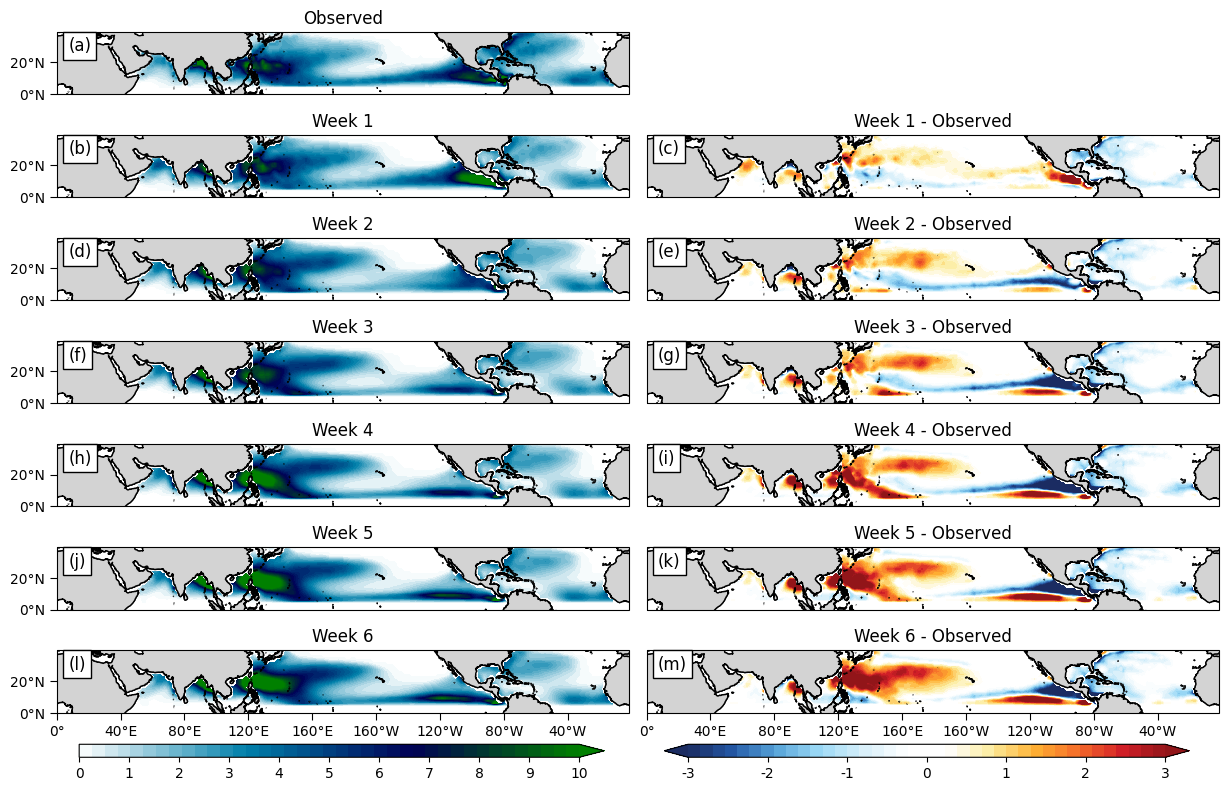

In [11]:

def process_dataset(filepath, selected_months, polygons=None):
    dataset = nc.Dataset(filepath)
    
    omega = dataset.variables['dgpi'][:]  
    lat = dataset.variables['lat'][:]  
    lon = dataset.variables['lon'][:]  
    time = dataset.variables['time'][:]  
    time_units = dataset.variables['time'].units
    calendar = dataset.variables['time'].calendar if 'calendar' in dataset.variables['time'].ncattrs() else 'gregorian'
    dates = num2date(time, units=time_units, calendar=calendar)
    months = np.array([d.month for d in dates])
    month_indices = np.where(np.isin(months, selected_months))[0]

    omega_subset = omega[month_indices, :, :]
    lat_min, lat_max = 0, 40
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lat_subset = lat[lat_indices]
    lon_subset = lon

    omega_filtered = omega_subset[:, lat_indices, :]

    mean_omega = np.mean(omega_filtered, axis=0)
    lon_subset = np.where(lon_subset < 0, lon_subset + 360, lon_subset)
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    if polygons:
        mask = np.zeros(lon_grid.shape, dtype=bool)
        for polygon in polygons:
            path = mpath.Path(polygon)
            for i in range(lon_grid.shape[0]):
                for j in range(lon_grid.shape[1]):
                    if path.contains_point((lon_grid[i, j], lat_grid[i, j])):
                        mask[i, j] = True
        mean_omega[~mask] = np.nan  

    return lon_grid, lat_grid, mean_omega

polygon_coordsi = np.array([[30, 0], [100, 0], [100, 31], [30, 31], [30, 0]])
polygon_coords = np.array([[100, 0], [180, 0], [180, 40], [100, 40], [100, 0]])
polygon_coords1 = np.array([[180, 0], [290, 0], [260, 20], [260, 40], [180, 40], [180, 0]])
polygon_coords2 = np.array([[290, 0], [260, 20], [260, 40], [360, 40], [360, 0], [290, 0]])
polygons = [polygon_coordsi, polygon_coords, polygon_coords1, polygon_coords2]

filepaths = [
    'Data_TC/Spatial/large_scale/dgpi_obs_clim.nc',
    'Data_TC/Spatial/large_scale/week1/dgpi.nc',
    'Data_TC/Spatial/large_scale/week2/dgpi.nc',
    'Data_TC/Spatial/large_scale/week3/dgpi.nc',
    'Data_TC/Spatial/large_scale/week4/dgpi.nc',
    'Data_TC/Spatial/large_scale/week5/dgpi.nc',
    'Data_TC/Spatial/large_scale/week6/dgpi.nc'
]

selected_months = np.array([5, 6, 7, 8, 9, 10])  

observed_filepath = filepaths[0]
lon_grid, lat_grid, observed_omega = process_dataset(observed_filepath, selected_months, polygons)
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()

vmin, vmax = 0, 10
diff_vmin, diff_vmax = -3, 3

ax_observed = axes[0]
ax_observed.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
ax_observed.add_feature(cfeature.COASTLINE)
ax_observed.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

c = ax_observed.contourf(lon_grid, lat_grid, observed_omega, cmap='ocean_r', levels=np.linspace(vmin, vmax, 40),
                         vmin=vmin, vmax=vmax, extend='max', transform=ccrs.PlateCarree())
ax_observed.set_title('Observed')

axes[1].set_visible(False)
for i, filepath in enumerate(filepaths[1:]):
    _, _, weekly_omega = process_dataset(filepath, selected_months, polygons)

    ax = axes[(i + 1) * 2]
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    ax.contourf(lon_grid, lat_grid, weekly_omega, cmap='ocean_r', levels=np.linspace(vmin, vmax, 40),
                vmin=vmin, vmax=vmax, extend='max', transform=ccrs.PlateCarree())

    ax.set_title(f'Week {i+1}')
    ax_diff = axes[(i + 1) * 2 + 1]
    difference = weekly_omega - observed_omega
    
    ax_diff.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax_diff.add_feature(cfeature.COASTLINE)
    ax_diff.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k = ax_diff.contourf(lon_grid, lat_grid, difference, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(diff_vmin, diff_vmax, 40),
                         vmin=diff_vmin, vmax=diff_vmax, extend='both', transform=ccrs.PlateCarree())

    ax_diff.set_title(f'Week {i+1} - Observed')

for i, ax in enumerate(axes): 
    if ax.get_visible(): 
        if i % 2 == 0: 
            ax.set_yticks(np.arange(0, 40, 20), crs=ccrs.PlateCarree())
            lat_labels = [f"{abs(lat)}°S" if lat < 0 else f"{lat}°N" for lat in np.arange(0, 40, 20)]
            ax.set_yticklabels(lat_labels, fontsize=10)
        else:  
            ax.yaxis.set_visible(False)
        if i >= len(axes) - 2: 
            lon_ticks = [0, 40, 80, 120, 160, 200, 240, 280, 320] 
            lon_labels = ['0°', '40°E', '80°E', '120°E', '160°E', '160°W', '120°W', '80°W', '40°W']
            ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
            ax.set_xticklabels(lon_labels, fontsize=10, color='black')
        else:  
            ax.set_xticks([])  
        ax.tick_params(axis='both', colors='k', size=5)
        gl = ax.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
        gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
        gl.ylocator = plt.FixedLocator(np.arange(0, 40, 20))

        labels = ['(a)', 'b','(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        if i < len(labels):
            label = labels[i]
        else:
            label = chr(97 + i) 
        ax.text(
            0.02, 0.92, label, 
            transform=ax.transAxes, 
            fontsize=12, 
            va='top', 
            ha='left', 
            color='k',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3')
        )

cbar_ax1 = fig.add_axes([0.14, 0.11, 0.35, 0.013])  
cbar1 = fig.colorbar(c, cax=cbar_ax1, orientation='horizontal', pad=0.1)
cbar1.set_ticks(np.linspace(vmin, vmax, 11))  
cbar1.set_ticklabels([str(int(tick)) for tick in np.linspace(vmin, vmax, 11)])

cbar_ax2 = fig.add_axes([0.53, 0.11, 0.35, 0.013])  
cbar2 = fig.colorbar(k, cax=cbar_ax2, orientation='horizontal', pad=0.1)
cbar2.set_ticks(np.linspace(diff_vmin, diff_vmax, 7))  
cbar2.set_ticklabels([str(int(tick)) for tick in np.linspace(diff_vmin, diff_vmax, 7)])
plt.subplots_adjust(hspace=-0.32, wspace=0.03)
#plt.savefig('Figures/Supplementary/FigureS7.png', dpi=400, bbox_inches='tight')
plt.show()


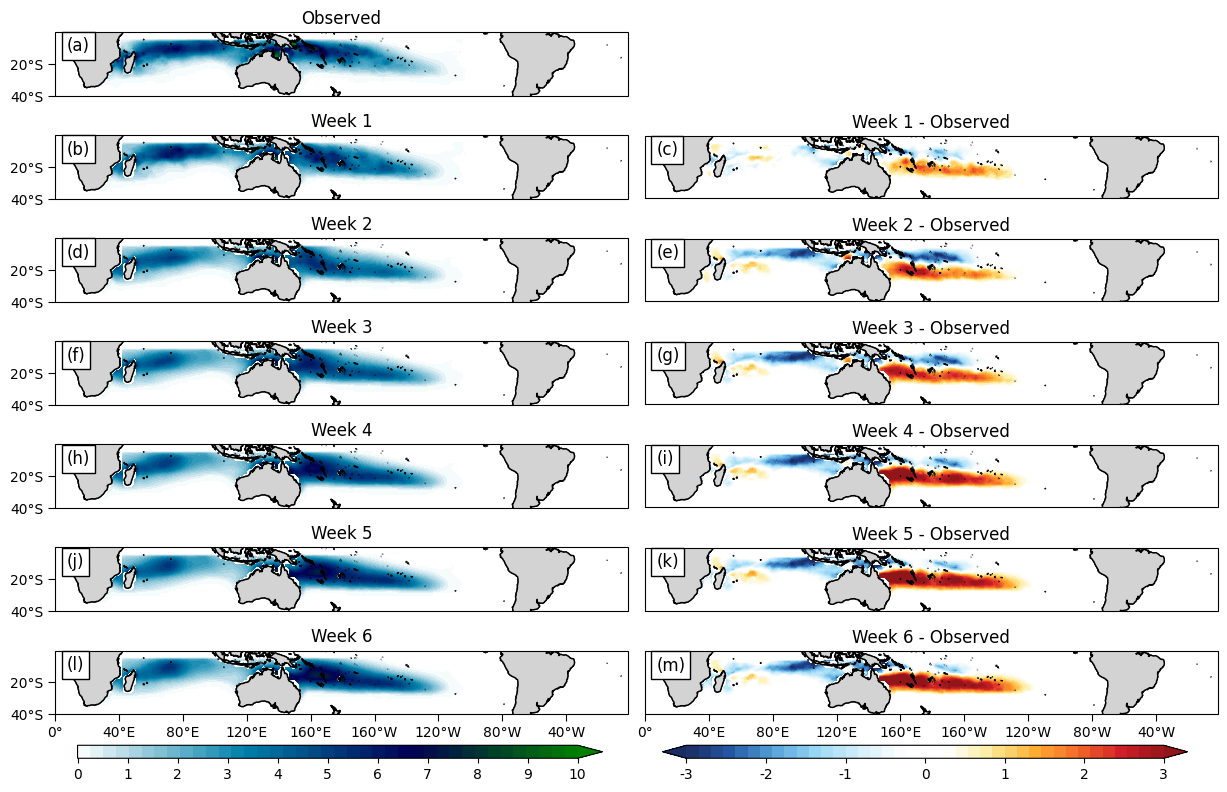

In [12]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import num2date
import matplotlib.path as mpath
import cmaps

def process_dataset(filepath, selected_months, polygons=None):
    dataset = nc.Dataset(filepath)
    
    omega = dataset.variables['dgpi'][:]  
    lat = dataset.variables['lat'][:]  
    lon = dataset.variables['lon'][:] 
    time = dataset.variables['time'][:] 
    time_units = dataset.variables['time'].units
    calendar = dataset.variables['time'].calendar if 'calendar' in dataset.variables['time'].ncattrs() else 'gregorian'
    dates = num2date(time, units=time_units, calendar=calendar)
    months = np.array([d.month for d in dates])
    month_indices = np.where(np.isin(months, selected_months))[0]

    omega_subset = omega[month_indices, :, :]
    lat_min, lat_max = -40, 0
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lat_subset = lat[lat_indices]
    lon_subset = lon
    omega_filtered = omega_subset[:, lat_indices, :]
    mean_omega = np.mean(omega_filtered, axis=0)

    lon_subset = np.where(lon_subset < 0, lon_subset + 360, lon_subset)
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)
    if polygons:
        mask = np.zeros(lon_grid.shape, dtype=bool)
        for polygon in polygons:
            path = mpath.Path(polygon)
            for i in range(lon_grid.shape[0]):
                for j in range(lon_grid.shape[1]):
                    if path.contains_point((lon_grid[i, j], lat_grid[i, j])):
                        mask[i, j] = True
        mean_omega[~mask] = np.nan  

    return lon_grid, lat_grid, mean_omega


polygon_coordsh = np.array([[30, 0], [30, -40], [258, -40], [256, 0]])
polygons = [polygon_coordsh]


filepaths = [
    'Data_TC/Spatial/large_scale/dgpi_obs_clim.nc',
    'Data_TC/Spatial/large_scale/week1/dgpi.nc',
    'Data_TC/Spatial/large_scale/week2/dgpi.nc',
    'Data_TC/Spatial/large_scale/week3/dgpi.nc',
    'Data_TC/Spatial/large_scale/week4/dgpi.nc',
    'Data_TC/Spatial/large_scale/week5/dgpi.nc',
    'Data_TC/Spatial/large_scale/week6/dgpi.nc'
]

selected_months = np.array([1,2,3,4,11,12])  
observed_filepath = filepaths[0]
lon_grid, lat_grid, observed_omega = process_dataset(observed_filepath, selected_months, polygons)
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()

vmin, vmax = 0, 10
diff_vmin, diff_vmax = -3, 3

ax_observed = axes[0]
ax_observed.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
ax_observed.add_feature(cfeature.COASTLINE)
ax_observed.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

c = ax_observed.contourf(lon_grid, lat_grid, observed_omega, cmap='ocean_r', levels=np.linspace(vmin, vmax, 40),
                         vmin=vmin, vmax=vmax, extend='max', transform=ccrs.PlateCarree())
ax_observed.set_title('Observed')
axes[1].set_visible(False)

for i, filepath in enumerate(filepaths[1:]):
    _, _, weekly_omega = process_dataset(filepath, selected_months, polygons)

    ax = axes[(i + 1) * 2]
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    ax.contourf(lon_grid, lat_grid, weekly_omega, cmap='ocean_r', levels=np.linspace(vmin, vmax, 40),
                vmin=vmin, vmax=vmax, extend='max', transform=ccrs.PlateCarree())

    ax.set_title(f'Week {i+1}')
    ax_diff = axes[(i + 1) * 2 + 1]
    difference = weekly_omega - observed_omega
    
    ax_diff.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax_diff.add_feature(cfeature.COASTLINE)
    ax_diff.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k = ax_diff.contourf(lon_grid, lat_grid, difference, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(diff_vmin, diff_vmax, 40),
                         vmin=diff_vmin, vmax=diff_vmax, extend='both', transform=ccrs.PlateCarree())

    ax_diff.set_title(f'Week {i+1} - Observed')

for i, ax in enumerate(axes): 
    if ax.get_visible():
        if i % 2 == 0: 
            ax.set_yticks(np.arange(-40, 0, 20), crs=ccrs.PlateCarree())
            lat_labels = [f"{abs(lat)}°S" if lat < 0 else f"{lat}°N" for lat in np.arange(-40, 0, 20)]
            ax.set_yticklabels(lat_labels, fontsize=10)
        else:  
            ax.yaxis.set_visible(False)
        if i >= len(axes) - 2:  
            lon_ticks = [0, 40, 80, 120, 160, 200, 240, 280, 320]  # Corresponding to [0°, 40°E, ..., 40°W]
            lon_labels = ['0°', '40°E', '80°E', '120°E', '160°E', '160°W', '120°W', '80°W', '40°W']
            ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
            ax.set_xticklabels(lon_labels, fontsize=10, color='black')
        else:  
            ax.set_xticks([])  
        ax.tick_params(axis='both', colors='k', size=5)

        gl = ax.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
        gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
        gl.ylocator = plt.FixedLocator(np.arange(-40, 0, 20))

        # Add figure labels
        labels = ['(a)', 'b','(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        if i < len(labels):
            label = labels[i]
        else:
            label = chr(97 + i) 
        ax.text(
            0.02, 0.92, label, 
            transform=ax.transAxes, 
            fontsize=12, 
            va='top', 
            ha='left', 
            color='k',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3')
        )

cbar_ax1 = fig.add_axes([0.14, 0.11, 0.35, 0.013])  
cbar1 = fig.colorbar(c, cax=cbar_ax1, orientation='horizontal', pad=0.1)
cbar1.set_ticks(np.linspace(vmin, vmax, 11))  
cbar1.set_ticklabels([str(int(tick)) for tick in np.linspace(vmin, vmax, 11)])

cbar_ax2 = fig.add_axes([0.53, 0.11, 0.35, 0.013])  
cbar2 = fig.colorbar(k, cax=cbar_ax2, orientation='horizontal', pad=0.1)
cbar2.set_ticks(np.linspace(diff_vmin, diff_vmax, 7))  
cbar2.set_ticklabels([str(int(tick)) for tick in np.linspace(diff_vmin, diff_vmax, 7)])

plt.subplots_adjust(hspace=-0.32, wspace=0.03)
plt.savefig('Figures/Supplementary/FigureS8.png', dpi=400, bbox_inches='tight')
plt.show()


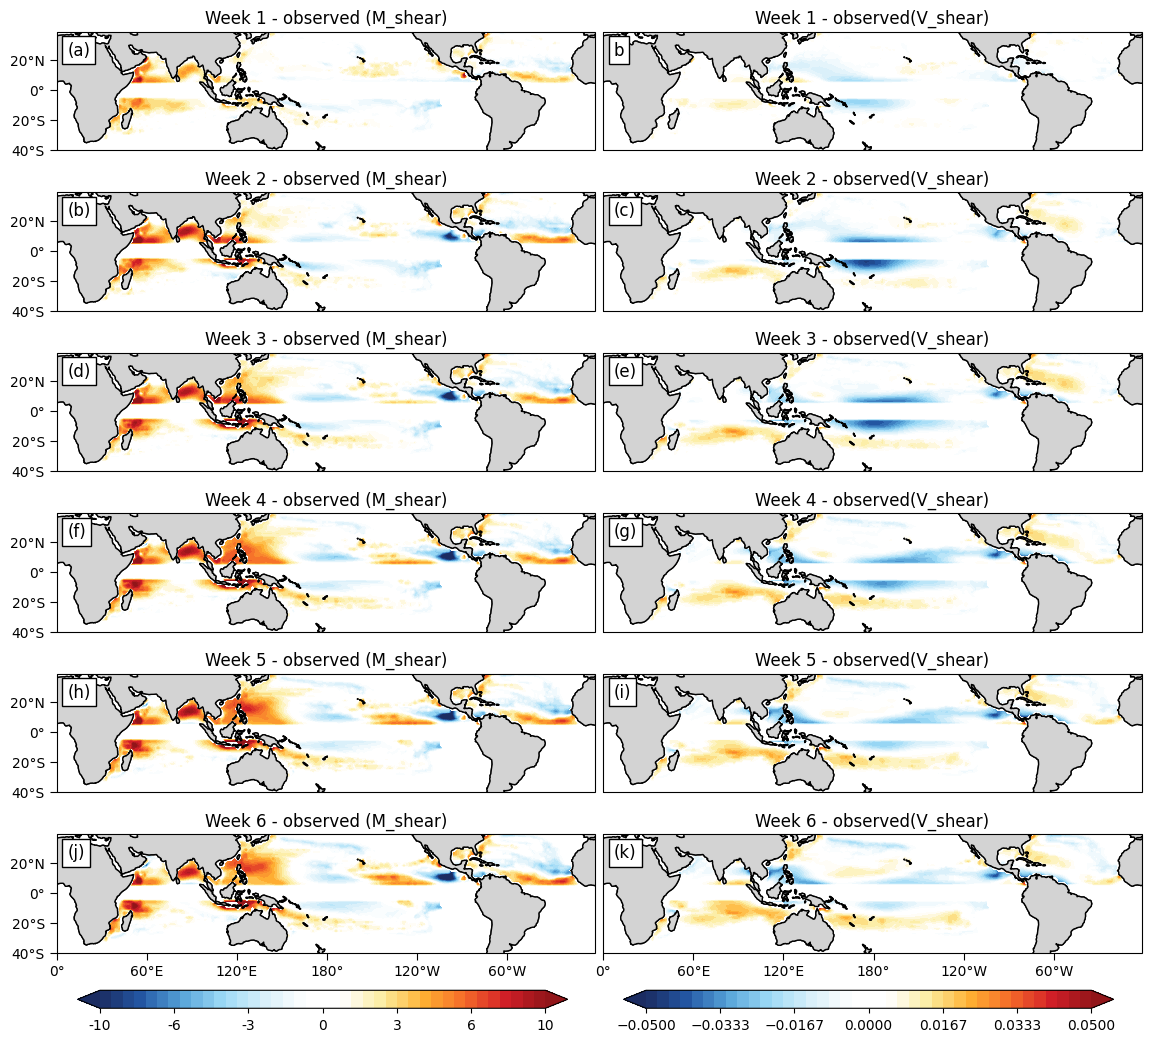

In [13]:

def process_dataset(filepath, selected_months, polygons=None):
    dataset = nc.Dataset(filepath)
    
    omega = dataset.variables['dudy'][:] 
    wshear = dataset.variables['wshear'][:] 
    lat = dataset.variables['lat'][:]  
    lon = dataset.variables['lon'][:]  
    time = dataset.variables['time'][:] 
    time_units = dataset.variables['time'].units
    calendar = dataset.variables['time'].calendar if 'calendar' in dataset.variables['time'].ncattrs() else 'gregorian'

    dates = num2date(time, units=time_units, calendar=calendar)
    months = np.array([d.month for d in dates])
    month_indices = np.where(np.isin(months, selected_months))[0]
    omega_subset = omega[month_indices, :, :]
    wshear_subset = wshear[month_indices, :, :]
    lat_min, lat_max = -40, 40
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lat_subset = lat[lat_indices]
    lon_subset = lon
    omega_filtered = omega_subset[:, lat_indices, :]
    wshear_filtered = wshear_subset[:, lat_indices, :]
    mean_omega = np.mean(omega_filtered, axis=0)
    mean_wshear = np.mean(wshear_filtered, axis=0)

    lon_subset = np.where(lon_subset < 0, lon_subset + 360, lon_subset)
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    if polygons:
        mask = np.zeros(lon_grid.shape, dtype=bool)
        for polygon in polygons:
            path = mpath.Path(polygon)
            for i in range(lon_grid.shape[0]):
                for j in range(lon_grid.shape[1]):
                    if path.contains_point((lon_grid[i, j], lat_grid[i, j])):
                        mask[i, j] = True
        mean_omega[~mask] = np.nan  
        mean_wshear[~mask] = np.nan  

    return lon_grid, lat_grid, mean_omega, mean_wshear

polygon_coordsi = np.array([[30, 0], [100, 0], [100, 31], [30, 31], [30, 0]])
polygon_coords = np.array([[100, 0], [180, 0], [180, 40], [100, 40], [100, 0]])
polygon_coords1 = np.array([[180, 0], [290, 0], [260, 20], [260, 40], [180, 40], [180, 0]])
polygon_coords2 = np.array([[290, 0], [260, 20], [260, 40], [360, 40], [360, 0], [290, 0]])
polygon_coordsh = np.array([[30, 0], [30, -40], [258, -40], [256, 0]])
polygons = [polygon_coordsi, polygon_coords, polygon_coords1, polygon_coords2, polygon_coordsh]

filepaths = [
    'Data_TC/Spatial/large_scale/dgpi_obs_clim.nc',
    'Data_TC/Spatial/large_scale/week1/dgpi.nc',
    'Data_TC/Spatial/large_scale/week2/dgpi.nc',
    'Data_TC/Spatial/large_scale/week3/dgpi.nc',
    'Data_TC/Spatial/large_scale/week4/dgpi.nc',
    'Data_TC/Spatial/large_scale/week5/dgpi.nc',
    'Data_TC/Spatial/large_scale/week6/dgpi.nc'
]

selected_months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])  
observed_filepath = filepaths[0]
lon_grid, lat_grid, observed_omega, observed_wshear = process_dataset(observed_filepath, selected_months, polygons)
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()
diff_vmin, diff_vmax = -10, 10
wshear_vmin, wshear_vmax = -0.05, 0.05  

for i, filepath in enumerate(filepaths[1:]):
    # Process weekly data
    _, _, weekly_omega, weekly_wshear = process_dataset(filepath, selected_months, polygons)

    ax_omega = axes[2*i]
    omega_diff = weekly_omega - observed_omega
    
    ax_omega.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax_omega.add_feature(cfeature.COASTLINE)
    ax_omega.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k_omega = ax_omega.contourf(lon_grid, lat_grid, omega_diff, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(diff_vmin, diff_vmax, 40),
                         vmin=diff_vmin, vmax=diff_vmax, extend='both', transform=ccrs.PlateCarree())
    ax_omega.set_title(f'Week {i+1} - observed (M_shear)')

    # Set y-ticks and x-ticks for omega plots
    ax_omega.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
    lat_labels = [f"{lat}°" for lat in np.arange(-40, 40, 20)]
    ax_omega.set_yticklabels(lat_labels, fontsize=10)

    ax_omega.set_xticks(np.arange(0, 361, 40), crs=ccrs.PlateCarree())
    lon_labels = [str((x if x <= 180 else x - 360)) + '°' for x in np.arange(0, 361, 40)]
    ax_omega.set_xticklabels(lon_labels, fontsize=10, color='white')

    ax_omega.tick_params(axis='both', colors='k', size=5)
    gl = ax_omega.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
    gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
    gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))

    ax_wshear = axes[2*i + 1]
    wshear_diff = weekly_wshear - observed_wshear

    ax_wshear.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax_wshear.add_feature(cfeature.COASTLINE)
    ax_wshear.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k_wshear = ax_wshear.contourf(lon_grid, lat_grid, wshear_diff, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(wshear_vmin, wshear_vmax, 40),
                         vmin=wshear_vmin, vmax=wshear_vmax, extend='both', transform=ccrs.PlateCarree())
    ax_wshear.set_title(f'Week {i+1} - observed(V_shear)')

    ax_wshear.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
    ax_wshear.set_yticklabels(lat_labels, fontsize=10)

    ax_wshear.set_xticks(np.arange(0, 361, 40), crs=ccrs.PlateCarree())
    ax_wshear.set_xticklabels(lon_labels, fontsize=10, color='white')

    ax_wshear.tick_params(axis='both', colors='k', size=5)
    gl = ax_wshear.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
    gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
    gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))

for i, ax in enumerate(axes):  
    if ax.get_visible():  
        if i % 2 == 0:  
            ax.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
            lat_ticks = [-40, -20, 0, 20]  # Corresponding to [0°, 40°E, ..., 40°W]
            lat_labels = ['40°S', '20°S', '0°', '20°N']
            ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
            
            ax.set_yticklabels(lat_labels, fontsize=10)
        else:  
            ax.yaxis.set_visible(False)

        if i >= len(axes) - 2: 
            lon_ticks = [0, 60, 120, 180, 240, 300]  
            lon_labels = ['0°', '60°E', '120°E', '180°', '120°W', '60°W']
            ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
            ax.set_xticklabels(lon_labels, fontsize=10, color='black')
        else: 
            ax.set_xticks([]) 
        ax.tick_params(axis='both', colors='k', size=5)
        gl = ax.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
        gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
        gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))

        labels = ['(a)', 'b','(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        if i < len(labels):
            label = labels[i]
        else:
            label = chr(97 + i) 
        ax.text(
            0.02, 0.92, label, 
            transform=ax.transAxes, 
            fontsize=12, 
            va='top', 
            ha='left', 
            color='k',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3')
        )

cbar_ax_omega = fig.add_axes([0.14, 0.06, 0.35, 0.015])  # Adjust [left, bottom, width, height]
cbar_omega = fig.colorbar(k_omega, cax=cbar_ax_omega, orientation='horizontal', pad=0.1)
cbar_omega.set_ticks(np.linspace(diff_vmin, diff_vmax, 7))  # Ticks from -10 to 10
cbar_omega.set_ticklabels([str(int(tick)) for tick in np.linspace(diff_vmin, diff_vmax, 7)])
cbar_ax_wshear = fig.add_axes([0.53, 0.06, 0.35, 0.015])  # Adjust [left, bottom, width, height]
cbar_wshear = fig.colorbar(k_wshear, cax=cbar_ax_wshear, orientation='horizontal', pad=0.1)
cbar_wshear.set_ticks(np.linspace(wshear_vmin, wshear_vmax, 7))  # Ticks from -0.05 to 0.05
plt.subplots_adjust(hspace=0.2, bottom=0.1,wspace=0.015,)

#plt.savefig('Figures/Supplementary/FigureS9.png', dpi=400, bbox_inches='tight')
plt.show()


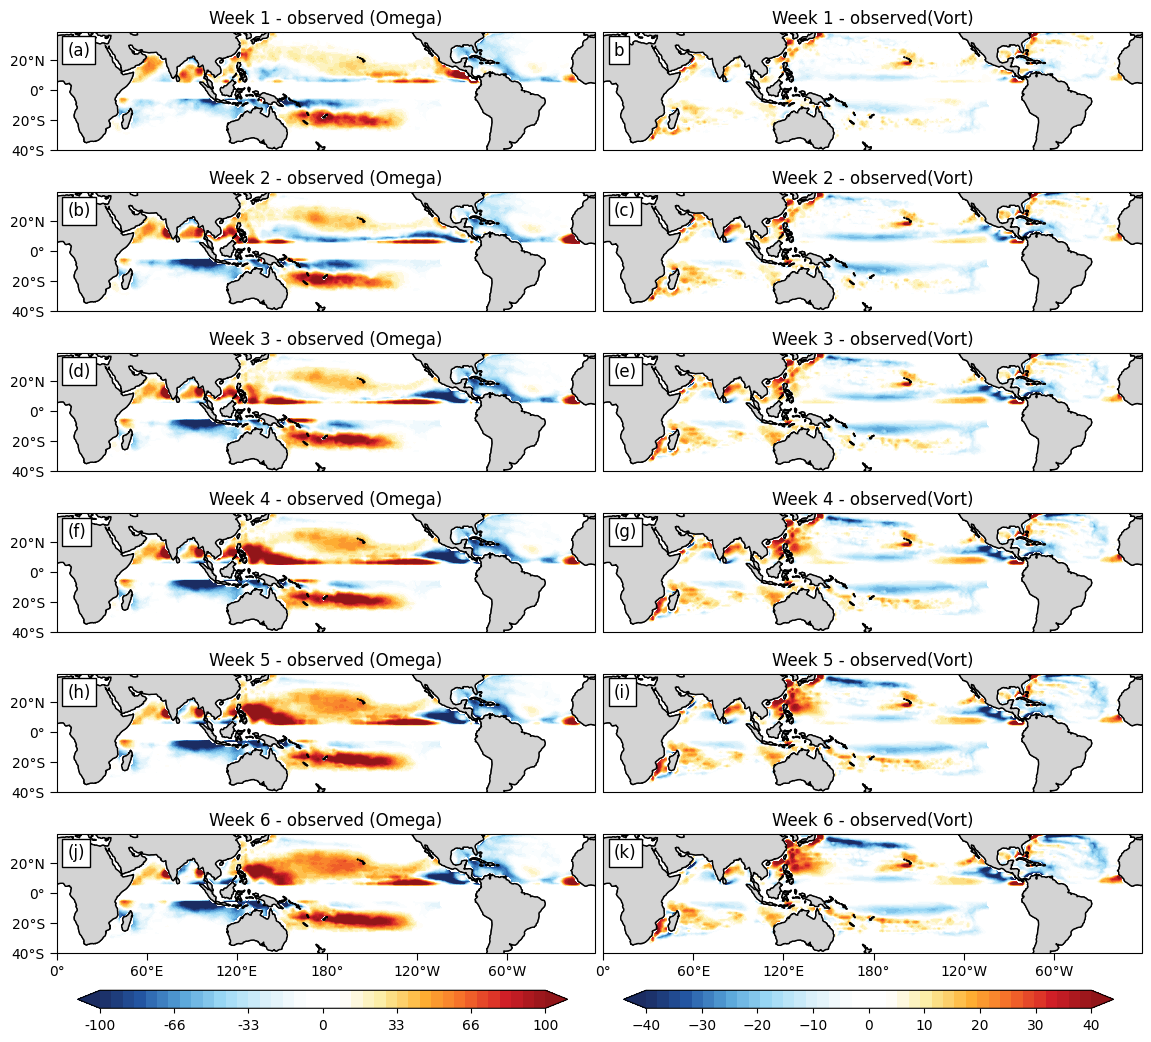

In [14]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import num2date
import matplotlib.path as mpath
import cmaps
def process_dataset(filepath, selected_months, polygons=None):
    dataset = nc.Dataset(filepath)
    
    omega = dataset.variables['omega'][:]  
    wshear = dataset.variables['avor'][:]  
    lat = dataset.variables['lat'][:]  
    lon = dataset.variables['lon'][:]  
    time = dataset.variables['time'][:] 
    time_units = dataset.variables['time'].units
    calendar = dataset.variables['time'].calendar if 'calendar' in dataset.variables['time'].ncattrs() else 'gregorian'
    dates = num2date(time, units=time_units, calendar=calendar)
    months = np.array([d.month for d in dates])
    month_indices = np.where(np.isin(months, selected_months))[0]

    omega_subset = omega[month_indices, :, :]
    wshear_subset = wshear[month_indices, :, :]
    lat_min, lat_max = -40, 40
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lat_subset = lat[lat_indices]
    lon_subset = lon
    omega_filtered = omega_subset[:, lat_indices, :]
    wshear_filtered = wshear_subset[:, lat_indices, :]
    mean_omega = np.mean(omega_filtered, axis=0)
    mean_wshear = np.mean(wshear_filtered, axis=0)
    lon_subset = np.where(lon_subset < 0, lon_subset + 360, lon_subset)

    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)
    if polygons:
        mask = np.zeros(lon_grid.shape, dtype=bool)
        for polygon in polygons:
            path = mpath.Path(polygon)
            for i in range(lon_grid.shape[0]):
                for j in range(lon_grid.shape[1]):
                    if path.contains_point((lon_grid[i, j], lat_grid[i, j])):
                        mask[i, j] = True
        mean_omega[~mask] = np.nan  
        mean_wshear[~mask] = np.nan  

    return lon_grid, lat_grid, mean_omega, mean_wshear

# Define polygons for masking
polygon_coordsi = np.array([[30, 0], [100, 0], [100, 31], [30, 31], [30, 0]])
polygon_coords = np.array([[100, 0], [180, 0], [180, 40], [100, 40], [100, 0]])
polygon_coords1 = np.array([[180, 0], [290, 0], [260, 20], [260, 40], [180, 40], [180, 0]])
polygon_coords2 = np.array([[290, 0], [260, 20], [260, 40], [360, 40], [360, 0], [290, 0]])
polygon_coordsh = np.array([[30, 0], [30, -40], [258, -40], [256, 0]])

polygons = [polygon_coordsi, polygon_coords, polygon_coords1, polygon_coords2, polygon_coordsh]

filepaths = [
    'Data_TC/Spatial/large_scale/dgpi_obs.nc',
    'Data_TC/Spatial/large_scale/week1/dgpi.nc',
    'Data_TC/Spatial/large_scale/week2/dgpi.nc',
    'Data_TC/Spatial/large_scale/week3/dgpi.nc',
    'Data_TC/Spatial/large_scale/week4/dgpi.nc',
    'Data_TC/Spatial/large_scale/week5/dgpi.nc',
    'Data_TC/Spatial/large_scale/week6/dgpi.nc'
]

selected_months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])  
observed_filepath = filepaths[0]
lon_grid, lat_grid, observed_omega, observed_wshear = process_dataset(observed_filepath, selected_months, polygons)
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()

diff_vmin, diff_vmax = -100, 100
wshear_vmin, wshear_vmax = -40, 40  
for i, filepath in enumerate(filepaths[1:]):
    # Process weekly data
    _, _, weekly_omega, weekly_wshear = process_dataset(filepath, selected_months, polygons)
    ax_omega = axes[2*i]
    omega_diff = weekly_omega - observed_omega
    
    ax_omega.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax_omega.add_feature(cfeature.COASTLINE)
    ax_omega.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k_omega = ax_omega.contourf(lon_grid, lat_grid, omega_diff, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(diff_vmin, diff_vmax, 40),
                         vmin=diff_vmin, vmax=diff_vmax, extend='both', transform=ccrs.PlateCarree())
    ax_omega.set_title(f'Week {i+1} - observed (Omega)')

    # Set y-ticks and x-ticks for omega plots
    ax_omega.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
    lat_labels = [f"{lat}°" for lat in np.arange(-40, 40, 20)]
    ax_omega.set_yticklabels(lat_labels, fontsize=10)

    ax_omega.set_xticks(np.arange(0, 361, 40), crs=ccrs.PlateCarree())
    lon_labels = [str((x if x <= 180 else x - 360)) + '°' for x in np.arange(0, 361, 40)]
    ax_omega.set_xticklabels(lon_labels, fontsize=10, color='white')

    ax_omega.tick_params(axis='both', colors='k', size=5)
    gl = ax_omega.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
    gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
    gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))
    ax_wshear = axes[2*i + 1]
    wshear_diff = weekly_wshear - observed_wshear

    ax_wshear.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', zorder=2)
    ax_wshear.add_feature(cfeature.COASTLINE)
    ax_wshear.add_feature(cfeature.LAKES, facecolor='white', edgecolor='white')

    k_wshear = ax_wshear.contourf(lon_grid, lat_grid, wshear_diff, cmap=cmaps.BlueWhiteOrangeRed, levels=np.linspace(wshear_vmin, wshear_vmax, 40),
                         vmin=wshear_vmin, vmax=wshear_vmax, extend='both', transform=ccrs.PlateCarree())
    ax_wshear.set_title(f'Week {i+1} - observed(Vort)')
    ax_wshear.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
    ax_wshear.set_yticklabels(lat_labels, fontsize=10)

    ax_wshear.set_xticks(np.arange(0, 361, 40), crs=ccrs.PlateCarree())
    ax_wshear.set_xticklabels(lon_labels, fontsize=10, color='white')

    ax_wshear.tick_params(axis='both', colors='k', size=5)
    gl = ax_wshear.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
    gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
    gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))
    
for i, ax in enumerate(axes): 
    if ax.get_visible(): 
        if i % 2 == 0:  
            ax.set_yticks(np.arange(-40, 40, 20), crs=ccrs.PlateCarree())
            lat_ticks = [-40, -20, 0, 20]  
            lat_labels = ['40°S', '20°S', '0°', '20°N']
            ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
            ax.set_yticklabels(lat_labels, fontsize=10)
        else:  
            ax.yaxis.set_visible(False)

        if i >= len(axes) - 2: 
            lon_ticks = [0, 60, 120, 180, 240, 300] 
            lon_labels = ['0°', '60°E', '120°E', '180°', '120°W', '60°W']
            ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
            ax.set_xticklabels(lon_labels, fontsize=10, color='black')
        else:  
            ax.set_xticks([])  
        ax.tick_params(axis='both', colors='k', size=5)
        gl = ax.gridlines(draw_labels=False, color='none', linestyle='--', linewidth=0.000001)
        gl.xlocator = plt.FixedLocator(np.arange(0, 361, 40))
        gl.ylocator = plt.FixedLocator(np.arange(-40, 40, 20))
        labels = ['(a)', 'b','(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        if i < len(labels):
            label = labels[i]
        else:
            label = chr(97 + i) 
        ax.text(
            0.02, 0.92, label, 
            transform=ax.transAxes, 
            fontsize=12, 
            va='top', 
            ha='left', 
            color='k',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3')
        )

cbar_ax_omega = fig.add_axes([0.14, 0.06, 0.35, 0.015]) 
cbar_omega = fig.colorbar(k_omega, cax=cbar_ax_omega, orientation='horizontal', pad=0.1)
cbar_omega.set_ticks(np.linspace(diff_vmin, diff_vmax, 7)) 
cbar_omega.set_ticklabels([str(int(tick)) for tick in np.linspace(diff_vmin, diff_vmax, 7)])
cbar_ax_wshear = fig.add_axes([0.53, 0.06, 0.35, 0.015]) 
cbar_wshear = fig.colorbar(k_wshear, cax=cbar_ax_wshear, orientation='horizontal', pad=0.1)
cbar_wshear.set_ticks(np.linspace(wshear_vmin, wshear_vmax, 9)) 

plt.subplots_adjust(hspace=0.2, bottom=0.1,wspace=0.015,)
#plt.savefig('Figures/Supplementary/FigureS10.png', dpi=400, bbox_inches='tight')
plt.show()


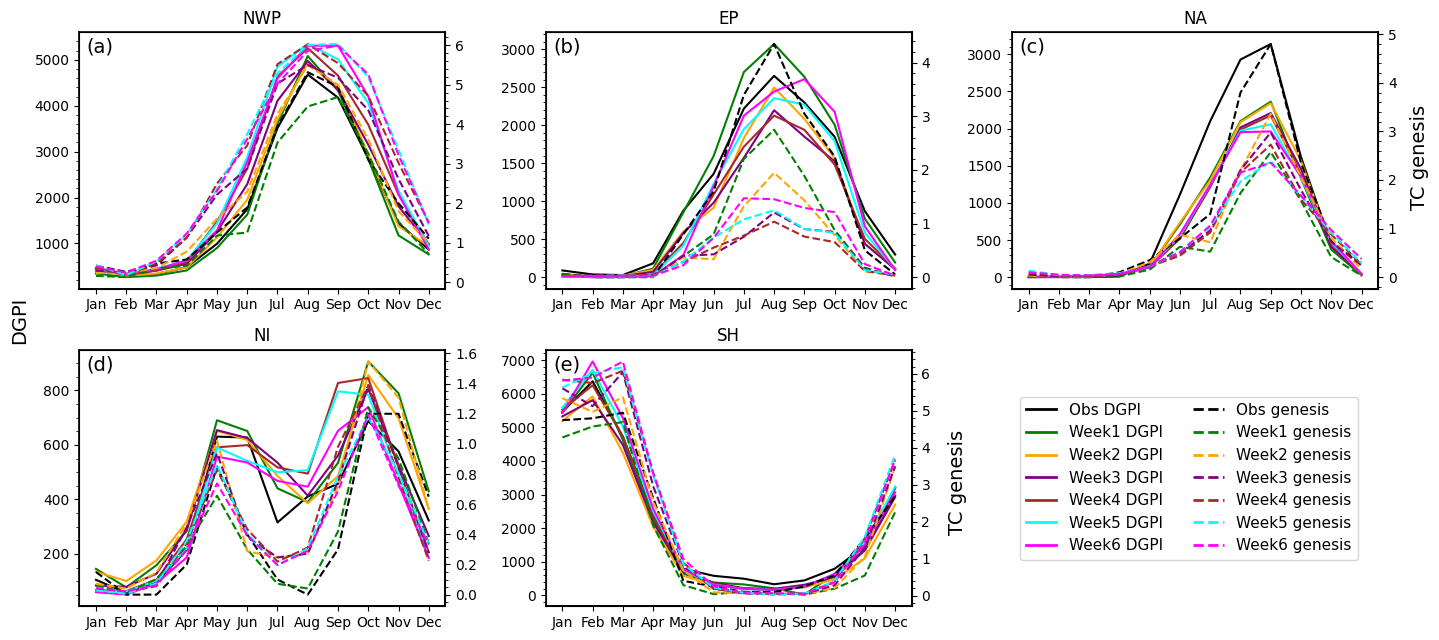

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
df = pd.read_csv('Data_TC/Proc/TC_and_DGPI_monthly_Avg_all_basins.csv')

basins = {
    'WP': ['DGPI_WP', 'DGPI_WP1', 'DGPI_WP2', 'DGPI_WP3', 'DGPI_WP4', 'DGPI_WP5', 'DGPI_WP6', 'WP', 'wp_week1_lag0', 'wp_week2_lag0', 'wp_week3_lag0', 'wp_week4_lag0', 'wp_week5_lag0', 'wp_week6_lag0'],
    'EP': ['DGPI_EP', 'DGPI_EP1', 'DGPI_EP2', 'DGPI_EP3', 'DGPI_EP4', 'DGPI_EP5', 'DGPI_EP6', 'EP', 'EP_week1_lag0', 'EP_week2_lag0', 'EP_week3_lag0', 'EP_week4_lag0', 'EP_week5_lag0', 'EP_week6_lag0'],
    'NA': ['DGPI_NA', 'DGPI_NA1', 'DGPI_NA2', 'DGPI_NA3', 'DGPI_NA4', 'DGPI_NA5', 'DGPI_NA6', 'NA', 'NA_week1_lag0', 'NA_week2_lag0', 'NA_week3_lag0', 'NA_week4_lag0', 'NA_week5_lag0', 'NA_week6_lag0'],
    'NI': ['DGPI_NI', 'DGPI_NI1', 'DGPI_NI2', 'DGPI_NI3', 'DGPI_NI4', 'DGPI_NI5', 'DGPI_NI6', 'NI', 'NI_week1_lag0', 'NI_week2_lag0', 'NI_week3_lag0', 'NI_week4_lag0', 'NI_week5_lag0', 'NI_week6_lag0'],
    'SH': ['DGPI_SH', 'DGPI_SH1', 'DGPI_SH2', 'DGPI_SH3', 'DGPI_SH4', 'DGPI_SH5', 'DGPI_SH6', 'SH', 'SH_week1_lag0', 'SH_week2_lag0', 'SH_week3_lag0', 'SH_week4_lag0', 'SH_week5_lag0', 'SH_week6_lag0']
}

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axs = plt.subplots(2, 3, figsize=(14, 6.5))
axs = axs.flatten()

basin_titles = ['NWP', 'EP', 'NA', 'NI', 'SH']

for idx, (basin, columns) in enumerate(basins.items()):
    ax1 = axs[idx]  
    ax2 = ax1.twinx()  

    ax1.plot(df['Month'], df[columns[0]], label=f'DGPI_{basin}', color='k', linestyle='-')
    ax1.plot(df['Month'], df[columns[1]], label=f'DGPI_{basin}1', color='green', linestyle='-')
    ax1.plot(df['Month'], df[columns[2]], label=f'DGPI_{basin}2', color='orange', linestyle='-')
    ax1.plot(df['Month'], df[columns[3]], label=f'DGPI_{basin}3', color='purple', linestyle='-')
    ax1.plot(df['Month'], df[columns[4]], label=f'DGPI_{basin}4', color='brown', linestyle='-')
    ax1.plot(df['Month'], df[columns[5]], label=f'DGPI_{basin}5', color='cyan', linestyle='-')
    ax1.plot(df['Month'], df[columns[6]], label=f'DGPI_{basin}6', color='magenta', linestyle='-')

    ax1.tick_params(axis='y', labelcolor='k')
    ax1.minorticks_on()

    ax2.plot(df['Month'], df[columns[7]], label=f'{basin}', color='k', linestyle='--')
    ax2.plot(df['Month'], df[columns[8]], label=f'{basin}_week1_lag0', color='green', linestyle='--')
    ax2.plot(df['Month'], df[columns[9]], label=f'{basin}_week2_lag0', color='orange', linestyle='--')
    ax2.plot(df['Month'], df[columns[10]], label=f'{basin}_week3_lag0', color='purple', linestyle='--')
    ax2.plot(df['Month'], df[columns[11]], label=f'{basin}_week4_lag0', color='brown', linestyle='--')
    ax2.plot(df['Month'], df[columns[12]], label=f'{basin}_week5_lag0', color='cyan', linestyle='--')
    ax2.plot(df['Month'], df[columns[13]], label=f'{basin}_week6_lag0', color='magenta', linestyle='--')

    ax2.tick_params(axis='y', labelcolor='k')
    ax2.minorticks_on()
    
    ax1.xaxis.set_minor_locator(plt.NullLocator())
    ax1.set_xticks(df['Month'])  
    ax1.set_xticklabels(months)  
    ax1.set_title(basin_titles[idx])
    ax1.text(0.02, 0.92, f'({chr(97 + idx)})', fontsize=14,  transform=ax1.transAxes) 

axs[5].axis('off') 

solid_lines = [
    plt.Line2D([0], [0], color='k', linestyle='-', label='Obs DGPI', linewidth=2,),
    plt.Line2D([0], [0], color='green', linestyle='-', label='Week1 DGPI', linewidth=2),
    plt.Line2D([0], [0], color='orange', linestyle='-', label='Week2 DGPI', linewidth=2),
    plt.Line2D([0], [0], color='purple', linestyle='-', label='Week3 DGPI', linewidth=2),
    plt.Line2D([0], [0], color='brown', linestyle='-', label='Week4 DGPI', linewidth=2),
    plt.Line2D([0], [0], color='cyan', linestyle='-', label='Week5 DGPI', linewidth=2),
    plt.Line2D([0], [0], color='magenta', linestyle='-', label='Week6 DGPI', linewidth=2)
]

dashed_lines = [
    plt.Line2D([0], [0], color='k', linestyle='--', label='Obs genesis', linewidth=2),
    plt.Line2D([0], [0], color='green', linestyle='--', label='Week1 genesis', linewidth=2),
    plt.Line2D([0], [0], color='orange', linestyle='--', label='Week2 genesis', linewidth=2),
    plt.Line2D([0], [0], color='purple', linestyle='--', label='Week3 genesis', linewidth=2),
    plt.Line2D([0], [0], color='brown', linestyle='--', label='Week4 genesis', linewidth=2),
    plt.Line2D([0], [0], color='cyan', linestyle='--', label='Week5 genesis', linewidth=2),
    plt.Line2D([0], [0], color='magenta', linestyle='--', label='Week6 genesis', linewidth=2)
]

# Add custom legend to the 6th subplot
axs[5].legend(handles=solid_lines + dashed_lines, loc='center left', ncol=2, frameon=True, fontsize=11)

# Add custom labels to the plot
fig.text(0.00, 0.5, 'DGPI', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(1, 0.75, 'TC genesis', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.67, 0.25, 'TC genesis', ha='center', va='center', rotation='vertical', fontsize=14)

for ax in axs.flat:
    ax.spines['left'].set_linewidth(1.2)   
    ax.spines['right'].set_linewidth(1.4)  
    ax.spines['top'].set_linewidth(1.2)    
    ax.spines['bottom'].set_linewidth(1.4) 

plt.tight_layout()
#plt.savefig('Figures/Supplementary/FigureS11.png', dpi=500, bbox_inches='tight')
# Show plot
plt.show()
